<a href="https://colab.research.google.com/github/namdarine/TIF_Chicago_Project/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.wkt import loads
import warnings
warnings.filterwarnings("ignore")
import pickle
import folium
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
JJ_path = '/content/drive/MyDrive/IPRO497_Demographic Team/Final/data/'
K_path = '/Users/kunwoosmac/Library/Mobile Documents/com~apple~CloudDocs/Python Workspace/IIT Courses/TIF DS Project/Final/data/'
L_path = '/content/drive/MyDrive/IPRO/IPRO 497 TIF Districts/IPRO497_Demographic Team/Final/data/'

JJ_path_image = '/content/drive/MyDrive/IPRO497_Demographic Team/Final/images/'

path = JJ_path
path_image = JJ_path_image


Community_area = gpd.read_file(path + 'Boundaries - Community Areas (current).geojson')

tifs = pd.read_csv(path + '2019_TIF_Boundaries.csv')
tifs = gpd.GeoDataFrame(tifs)
tifs = tifs.rename(columns={'the_geom': 'geometry'})
tifs['geometry'] = loads(tifs['geometry'])
tifs.set_geometry('geometry', inplace = True)

Blockgroup_boundary = pd.read_csv(path+'cleanBlockGroups.csv')
Blockgroup_boundary = Blockgroup_boundary.drop(columns=['coords'])
prefix = '1500000US'
Blockgroup_boundary['geoid'] = prefix + Blockgroup_boundary['geoid'].astype(str)


In [ ]:
filenames = ['year_race_community_Median_TIF.pickle', 'year_race_community_Median_Non_TIF.pickle',
             'year_race_community_Owner_TIF.pickle', 'year_race_community_Owner_Non_TIF.pickle',
             'year_race_community_Renter_TIF.pickle', 'year_race_community_Renter_Non_TIF.pickle',
             'year_race_community_Employment_TIF.pickle','year_race_community_Employment_Non_TIF.pickle',
             'year_race_community_Unemployment_TIF.pickle','year_race_community_Unemployment_Non_TIF.pickle'
            #  'year_race_community_EducationA_TIF.pickle','year_race_community_EducationA_Non_TIF.pickle',
            #  'year_race_community_EducationB_TIF.pickle','year_race_community_EducationB_Non_TIF.pickle',
            #  'year_race_community_EducationC_TIF.pickle','year_race_community_EducationC_Non_TIF.pickle',
            #  'year_race_community_EducationD_TIF.pickle','year_race_community_EducationD_Non_TIF.pickle',
            #  'year_race_community_EducationE_TIF.pickle','year_race_community_EducationE_Non_TIF.pickle',
            #  'year_race_community_EducationF_TIF.pickle','year_race_community_EducationF_Non_TIF.pickle',
            #  'year_race_community_EducationG_TIF.pickle','year_race_community_EducationG_Non_TIF.pickle'
             ]

first_iter = True
tif_yes = True

for filename in filenames:
    with open(path + filename, 'rb') as f:
        temp_df = pickle.load(f)
    if first_iter:
        temp_df_left = temp_df['Community']
        temp_df_right = temp_df.drop('Community', axis = 1, inplace = False)
        first_iter = False
    else:
        temp_df_right = temp_df.drop('Community', axis = 1, inplace = False)

    if tif_yes:
        temp_df_right.columns = ['TIF_' + col for col in temp_df_right.columns]
        tif_yes = False
    elif tif_yes == False:
        temp_df_right.columns = ['non-TIF_' + col for col in temp_df_right.columns]
        tif_yes = True


    temp_df_left = pd.concat((temp_df_left,temp_df_right), axis = 1)

year_list = np.array(['2017', '2018', '2019', '2020', '2021', '2022'])
race_list = ['White', 'Black', 'Latino(a)']

concatenated_df = temp_df_left
col_names = list(concatenated_df.columns)[1:]
communities = np.array(concatenated_df['Community'])

row_datas = []
new_column_names = []
first_comm = True

for community in communities:
    temp_row_data = []
    for col_name in col_names:
        list_by_year = list(concatenated_df[concatenated_df['Community'] == community][col_name].iloc[0])
        if first_comm:
            new_column_names += [year_list[i] + '_' + col_name for i in range(len(year_list))]
        temp_row_data += list_by_year
    row_datas.append(temp_row_data)
    first_comm = False

new_column_names.insert(0, 'Community')
df_for_clustering = pd.DataFrame(columns = new_column_names)

for idx, community, row in zip(range(len(communities)), communities, row_datas):
    temp_row = np.array([community] + row, dtype = object)
    try:
      df_for_clustering.loc[idx] = temp_row
    except:
      print(len(temp_row), len(new_column_names))

df_for_clustering

,Community,2017_TIF_Median Income of White,2018_TIF_Median Income of White,2019_TIF_Median Income of White,2020_TIF_Median Income of White,2021_TIF_Median Income of White,2022_TIF_Median Income of White,2017_TIF_Median Income of Black,2018_TIF_Median Income of Black,2019_TIF_Median Income of Black,...,2019_non-TIF_Unemployment of Black,2020_non-TIF_Unemployment of Black,2021_non-TIF_Unemployment of Black,2022_non-TIF_Unemployment of Black,2017_non-TIF_Unemployment of Latin,2018_non-TIF_Unemployment of Latin,2019_non-TIF_Unemployment of Latin,2020_non-TIF_Unemployment of Latin,2021_non-TIF_Unemployment of Latin,2022_non-TIF_Unemployment of Latin
0,DOUGLAS,38392.845982,37785.536208,40203.647947,44675.16526,50110.789317,56718.615168,31514.192258,31801.375386,31590.552167,...,3801.823632,3282.941839,3173.915563,3176.978112,156.435013,163.155993,156.427405,136.8376,130.800512,126.466045
1,OAKLAND,36190.837316,37429.425451,38114.058919,44701.273366,44414.451343,43924.666818,29441.116348,29420.084981,34206.560334,...,1001.838525,896.389589,1054.687858,1178.780437,13.087805,12.527064,12.830487,12.51984,15.174813,17.092608
2,FULLER PARK,27874.005718,28924.091578,29278.790919,23210.396778,22821.40513,24810.057313,24636.477351,24290.813452,23897.820464,...,207.325254,217.894859,237.749789,227.268053,9.941974,10.089099,9.578556,9.497142,9.508967,9.464876
3,GRAND BOULEVARD,38093.060994,40221.074045,41751.950495,40335.136501,41801.296816,45292.32139,33526.353631,34474.80197,35903.171654,...,622.380443,625.977212,651.956398,665.38404,15.840467,14.084686,11.935991,12.627088,12.916139,13.510534
4,KENWOOD,40994.246238,44553.177814,45562.265524,54449.659147,58864.343865,61094.499262,27580.264856,29797.42088,30381.441257,...,3555.947725,3717.667485,4007.404036,4077.597128,187.412259,179.333668,166.068385,162.073573,180.971507,186.529759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,MOUNT GREENWOOD,97957.126659,94520.266914,94342.067439,94379.303716,98432.729786,97830.125995,88275.177741,87472.3316,83415.510355,...,226.968767,234.235316,260.702882,256.492089,367.598536,376.837194,369.3167,372.817132,386.368909,363.228903
73,MORGAN PARK,67278.291666,65074.962099,71005.964151,70316.818145,73198.092999,71892.082455,41466.044625,43050.986094,46405.346999,...,1127.435952,994.432574,1004.797637,1106.87279,101.350667,102.278843,99.731949,88.320325,90.239107,95.165411
74,OHARE,67278.291666,65074.962099,71005.964151,70316.818145,73198.092999,71892.082455,41466.044625,43050.986094,46405.346999,...,163.218628,155.698981,154.008882,146.337705,1265.350464,1168.660192,1226.398922,1263.216053,1179.562794,1112.748412
75,EDGEWATER,49764.584151,53595.062195,55953.355574,58605.771688,61616.645096,65858.698322,40423.031381,44151.526012,45909.473646,...,302.110856,270.167185,259.130247,264.431476,625.90459,623.748512,640.204973,592.875298,581.847539,558.649672


In [ ]:
with open(path+'PCA_data.pickle', 'wb') as f:
	pickle.dump(df_for_clustering, f)

In [ ]:
with open(path + 'PCA_data.pickle', 'rb') as f:
    PCA_data = pickle.load(f)

# **1.** Determine the number of Pricipal Components

In [ ]:
x = PCA_data.copy()
features = x.columns[1:]
x = x.drop(['Community'],axis=1)
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x,columns=features)

In [ ]:
def calculate_number_of_PCA(x,percent):
  PCA_number = 30
  PCA_column = [f'Principal compennent {number}' for number in range(1,PCA_number+1)]
  pca = PCA(n_components=PCA_number)
  printcipalComponents = pca.fit_transform(x)
  sum = 0
  number_meet_condition = 0
  for number, explained_variance in enumerate(pca.explained_variance_ratio_):
    sum += explained_variance
    if sum >percent:
      number_meet_condition = number+1 # because number starts 0
      break

  PCA_number = np.arange(len(pca.explained_variance_ratio_))
  plt.figure(figsize=(10,5))
  plt.plot(PCA_number,pca.explained_variance_ratio_,color='k',label='PCA line')
  plt.title('Determine the number of Prinicipal Components')
  plt.xlabel('The number of Principal Components')
  plt.ylabel('% of Variance Explained')
  plt.axvline(number_meet_condition,color='r',label=f'{percent*100} % line')
  plt.xticks([0,1,2,3,4,5,6,7,8,9,10,15,20,25,30])
  plt.legend()
  # plt.grid()
  plt.savefig(JJ_path_image+'PCA/'+'Determine the number of Prinicipal Components',bbox_inches='tight')
  plt.show()
  print(f'The number of Pricipal Components of total {percent*100} % of Variance Explained  : ',number_meet_condition)

  return number_meet_condition

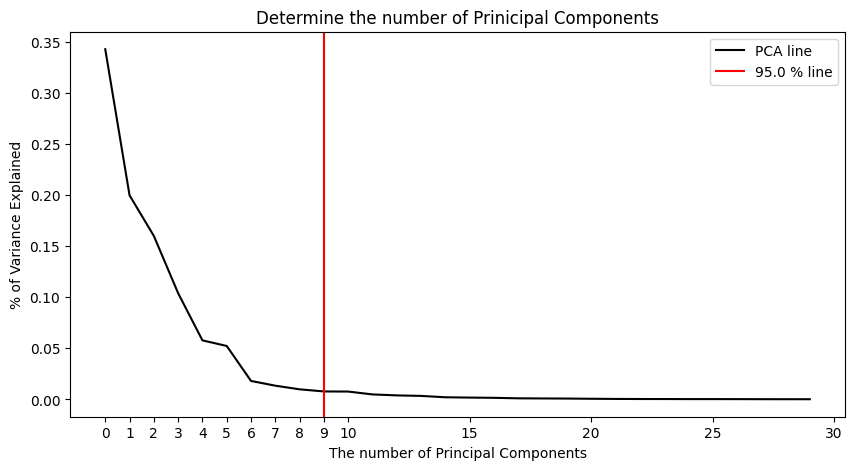

The number of Pricipal Components of total 95.0 % of Variance Explained  :  9


In [ ]:
PCA_number = calculate_number_of_PCA(x,0.95)

# **2.** Apply PCA

In [ ]:
y = PCA_data.copy()
features = y.columns[1:]
y = y.drop(['Community'],axis=1)
y = StandardScaler().fit_transform(y)
y = pd.DataFrame(y,columns=features)
PCA_column = [f'Principal compennent {number}' for number in range(1,PCA_number+1)]
pca = PCA(n_components=PCA_number)
printcipalComponents = pca.fit_transform(y)
principalDf = pd.DataFrame(data=printcipalComponents, columns = PCA_column)
principalDf



,Principal compennent 1,Principal compennent 2,Principal compennent 3,Principal compennent 4,Principal compennent 5,Principal compennent 6
0,-7.297456,-2.278161,0.510597,-1.119037,0.218041,0.691054
1,-5.987669,-0.513470,-3.595711,-4.024601,-1.831304,2.030395
2,-6.948566,0.852126,-3.632406,-5.900912,-1.068378,3.748651
3,-8.123894,-2.714079,3.399276,-3.727285,6.064428,-1.149279
4,-4.941124,-2.902994,-3.058438,0.882292,-3.542717,0.290811
...,...,...,...,...,...,...
72,5.815412,-6.394158,-6.325840,-1.478035,0.267237,-4.197574
73,-2.210824,-5.120868,0.465597,-2.021184,3.346804,-4.063464
74,-0.787148,-3.658592,0.127629,-1.049746,5.911318,0.689212
75,7.758169,0.833415,17.137857,-7.001209,-5.213333,0.741940


In [ ]:
with open(path + 'principal_Df.pickle', 'wb') as file:
    pickle.dump(principalDf, file)

In [ ]:
with open(path + 'principal_Df.pickle', 'rb') as f:
    test = pickle.load(f)

In [ ]:
test

,Principal compennent 1,Principal compennent 2,Principal compennent 3,Principal compennent 4,Principal compennent 5,Principal compennent 6,Principal compennent 7,Principal compennent 8
0,-10.862307,-1.715622,0.596569,-1.788719,-0.605749,0.225506,1.718100,-1.835932
1,-7.895269,-0.499393,-5.856075,-6.339410,-2.831443,1.300668,2.482379,-1.126579
2,-7.658385,0.451298,-6.035490,-8.866524,-1.463691,2.827552,3.971693,-0.767310
3,-12.051362,-2.557792,5.681080,-6.463390,8.495598,-1.250431,1.222450,-0.630850
4,-8.868866,-2.183429,-5.229134,1.004308,-5.982749,-1.008491,1.005362,-3.522989
...,...,...,...,...,...,...,...,...
72,1.282050,-7.578628,-10.289298,-1.704719,0.794930,-3.398388,-5.448571,2.182404
73,-7.131396,-5.246177,0.725177,-3.621093,4.502648,-3.268240,-2.888784,1.006640
74,-1.576773,-4.468754,-1.286838,0.266285,10.065863,3.583960,-0.663457,2.481062
75,15.440501,-12.317537,27.376882,-9.396468,-8.396961,5.792969,-0.943571,-0.591979


In [ ]:
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42564 sha256=6e9ea1da52a64ec2fea091bb8d7287abf36f318ecbae3570242b15e44223f044
  Stored in directory: /root/.cache/pip/wheels/24/59/82/6493618e30ed1cb7a013b9e1b0c9e17de80b04dfcef4ba8a4d
Successfully built factor_analyzer


In [ ]:
corr = x.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True, fmt='.1g')

<Axes: >

Error in callback <function flush_figures at 0x79904433c3a0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
corr

,2017_TIF_Median Income of White,2018_TIF_Median Income of White,2019_TIF_Median Income of White,2020_TIF_Median Income of White,2021_TIF_Median Income of White,2022_TIF_Median Income of White,2017_TIF_Median Income of Black,2018_TIF_Median Income of Black,2019_TIF_Median Income of Black,2020_TIF_Median Income of Black,...,2019_non-TIF_Graduate Degree of Black,2020_non-TIF_Graduate Degree of Black,2021_non-TIF_Graduate Degree of Black,2022_non-TIF_Graduate Degree of Black,2017_non-TIF_Graduate Degree of Latin,2018_non-TIF_Graduate Degree of Latin,2019_non-TIF_Graduate Degree of Latin,2020_non-TIF_Graduate Degree of Latin,2021_non-TIF_Graduate Degree of Latin,2022_non-TIF_Graduate Degree of Latin
2017_TIF_Median Income of White,1.000000,0.988201,0.979386,0.973960,0.968765,0.948811,0.767313,0.767528,0.771253,0.770071,...,0.150969,-0.042122,-0.051915,-0.049707,0.401908,0.396965,0.394732,0.331515,0.328468,0.324524
2018_TIF_Median Income of White,0.988201,1.000000,0.995180,0.984949,0.981732,0.969746,0.798411,0.814300,0.821472,0.820790,...,0.141347,-0.019700,-0.029264,-0.028190,0.449142,0.444766,0.441895,0.382253,0.378777,0.373861
2019_TIF_Median Income of White,0.979386,0.995180,1.000000,0.986478,0.982442,0.974034,0.783027,0.803704,0.820223,0.820388,...,0.140676,-0.017549,-0.027769,-0.026016,0.477933,0.473877,0.471927,0.413792,0.410020,0.405118
2020_TIF_Median Income of White,0.973960,0.984949,0.986478,1.000000,0.994201,0.986594,0.744649,0.765225,0.781263,0.801767,...,0.176327,0.002122,-0.006387,-0.005873,0.466945,0.462047,0.460346,0.402772,0.399430,0.393127
2021_TIF_Median Income of White,0.968765,0.981732,0.982442,0.994201,1.000000,0.988685,0.760644,0.780963,0.794133,0.816340,...,0.169709,0.005266,-0.002912,-0.003128,0.476662,0.472572,0.470528,0.416859,0.413812,0.406553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018_non-TIF_Graduate Degree of Latin,0.396965,0.444766,0.473877,0.462047,0.472572,0.497278,0.378344,0.419719,0.473187,0.482530,...,0.039803,0.022430,0.016564,0.020549,0.998439,1.000000,0.998634,0.988598,0.985159,0.981195
2019_non-TIF_Graduate Degree of Latin,0.394732,0.441895,0.471927,0.460346,0.470528,0.495016,0.370463,0.412352,0.466844,0.475649,...,0.037031,0.017332,0.012070,0.015757,0.995541,0.998634,1.000000,0.989763,0.986554,0.982762
2020_non-TIF_Graduate Degree of Latin,0.331515,0.382253,0.413792,0.402772,0.416859,0.441801,0.348467,0.388087,0.441358,0.456217,...,-0.018545,-0.002669,-0.006178,-0.002824,0.985446,0.988598,0.989763,1.000000,0.998197,0.995624
2021_non-TIF_Graduate Degree of Latin,0.328468,0.378777,0.410020,0.399430,0.413812,0.439037,0.342415,0.381021,0.432868,0.448241,...,-0.027004,-0.010219,-0.012244,-0.009025,0.982094,0.985159,0.986554,0.998197,1.000000,0.998426


In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(x)
chi_square_value, p_value

(inf, 0.0)

In [ ]:
x.isna().sum().sum()

0

In [ ]:
bartlett_test_statistic, bartlett_p_value = calculate_bartlett_sphericity(x)
print("Bartlett's Test Statistic:", bartlett_test_statistic)
print("Bartlett's p-value:", bartlett_p_value)

# Calculate KMO measure
kmo_all, kmo_model = calculate_kmo(x)
print("KMO Measure for Individual Variables:", kmo_all)
print("KMO Measure for the Overall Model:", kmo_model)

Bartlett's Test Statistic: inf
Bartlett's p-value: 0.0
KMO Measure for Individual Variables: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
KMO Measure for the Overall Model: nan


In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all,kmo_model=calculate_kmo(x)
kmo_model

nan

In [ ]:
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42564 sha256=d1b033c0c3443b08d597f095a0830d45482088562fbd44556c6108d247fbdf08
  Stored in directory: /root/.cache/pip/wheels/24/59/82/6493618e30ed1cb7a013b9e1b0c9e17de80b04dfcef4ba8a4d
Successfully built factor_analyzer
